In [1]:
!pip install category_encoders
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 779 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [4]:
import pandas as pd

import matplotlib.pyplot as plt
from category_encoders.binary import BinaryEncoder
import datetime
import numpy as np


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Prepare data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data.csv')
print(data.shape[0])
drop_names = ['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1' ]
for name in drop_names:
    data.pop(name)
data.pop('impressions')
data['date_time'] = pd.to_datetime(data['date_time'])
data['week_day'] = data['date_time'].dt.day_of_week
data['date'] = data['date_time'].dt.date
print(data.shape[0])
data = data.drop(1390198)
print(data.shape[0])
data_train = data.loc[data['date'] < datetime.date(2021, 10, 2)].drop_duplicates(subset=['zone_id',	'banner_id'	,'os_id',	'country_id', 'week_day', 'campaign_clicks'])
data_test = data.loc[data['date'] == datetime.date(2021, 10, 2)]
data = data_train.append(data_test)
print(data.shape[0])
bn = BinaryEncoder(cols = ['zone_id',	'banner_id'	,'os_id',	'country_id', 'week_day'])
data = bn.fit_transform(data)
data['campaign_clicks'] = (data['campaign_clicks'] - data['campaign_clicks'].mean()) / data['campaign_clicks'].std()
print(data.shape[0])

15821472
15821472
15821471
3137716
3137716


In [ ]:
data.columns

Index(['date_time', 'zone_id_0', 'zone_id_1', 'zone_id_2', 'zone_id_3',
       'zone_id_4', 'zone_id_5', 'zone_id_6', 'zone_id_7', 'zone_id_8',
       'zone_id_9', 'zone_id_10', 'zone_id_11', 'banner_id_0', 'banner_id_1',
       'banner_id_2', 'banner_id_3', 'banner_id_4', 'banner_id_5',
       'banner_id_6', 'banner_id_7', 'banner_id_8', 'banner_id_9',
       'banner_id_10', 'campaign_clicks', 'os_id_0', 'os_id_1', 'os_id_2',
       'os_id_3', 'country_id_0', 'country_id_1', 'country_id_2',
       'country_id_3', 'country_id_4', 'clicks', 'week_day_0', 'week_day_1',
       'week_day_2', 'date'],
      dtype='object')

In [ ]:
data.pop('date_time')
data_train = data.loc[data['date'] < datetime.date(2021, 10, 2)]
data_test = data.loc[data['date'] == datetime.date(2021, 10, 2)]
data_train.pop('date')
data_test.pop('date')
data_train.to_csv('/content/drive/MyDrive/data_train.csv', index=False)
data_test.to_csv('/content/drive/MyDrive/data_test.csv', index=False)



In [ ]:
pd.read_csv('/content/drive/MyDrive/data_train.csv')['clicks'].mean()

0.08985583967293787

In [ ]:
pd.read_csv('/content/drive/MyDrive/data_test.csv')['clicks'].mean()


0.035398205148197866

In [ ]:
pd.read_csv('/content/drive/MyDrive/data_test.csv').columns

Index(['zone_id_0', 'zone_id_1', 'zone_id_2', 'zone_id_3', 'zone_id_4',
       'zone_id_5', 'zone_id_6', 'zone_id_7', 'zone_id_8', 'zone_id_9',
       'zone_id_10', 'zone_id_11', 'banner_id_0', 'banner_id_1', 'banner_id_2',
       'banner_id_3', 'banner_id_4', 'banner_id_5', 'banner_id_6',
       'banner_id_7', 'banner_id_8', 'banner_id_9', 'banner_id_10',
       'campaign_clicks', 'os_id_0', 'os_id_1', 'os_id_2', 'os_id_3',
       'country_id_0', 'country_id_1', 'country_id_2', 'country_id_3',
       'country_id_4', 'clicks', 'week_day_0', 'week_day_1', 'week_day_2'],
      dtype='object')

Fine tune hyper parameters

In [2]:
from catboost import (CatBoostClassifier, Pool, sum_models, cv,)
from catboost.utils import eval_metric
from math import log


In [101]:
features = ['zone_id_0', 'zone_id_1', 'zone_id_2', 'zone_id_3', 'zone_id_4',
       'zone_id_5', 'zone_id_6', 'zone_id_7', 'zone_id_8', 'zone_id_9',
       'zone_id_10', 'zone_id_11', 'banner_id_0', 'banner_id_1', 'banner_id_2',
       'banner_id_3', 'banner_id_4', 'banner_id_5', 'banner_id_6',
       'banner_id_7', 'banner_id_8', 'banner_id_9', 'banner_id_10', 'os_id_0',
       'os_id_1', 'os_id_2', 'os_id_3', 'country_id_0', 'country_id_1',
       'country_id_2', 'country_id_3', 'country_id_4', 'week_day_0',
       'week_day_1', 'week_day_2', 'campaign_clicks']

label = 'clicks'

data = pd.read_csv('/content/drive/MyDrive/data_train.csv')

cv_dataset = Pool(data=data[features],
                  label=data[label])

for reg in [0.1, 0.01, 0.001, 0.0001]:
  params = {"iterations": 500,
          "depth": 2,
          'loss_function' : 'Logloss',
          'eval_metric' : 'AUC',
          "verbose": 1,
          "l2_leaf_reg": reg,
          'custom_metric' : 'AUC:hints=skip_train~false'}
  scores = cv(cv_dataset,
            params,
            fold_count=5, 
            plot="True")



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.5141345	test: 0.5134438	best: 0.5134438 (0)	total: 181ms	remaining: 1m 30s
1:	learn: 0.6265173	test: 0.6256105	best: 0.6256105 (1)	total: 358ms	remaining: 1m 29s
2:	learn: 0.6217803	test: 0.6203884	best: 0.6256105 (1)	total: 541ms	remaining: 1m 29s
3:	learn: 0.6250984	test: 0.6257078	best: 0.6257078 (3)	total: 713ms	remaining: 1m 28s
4:	learn: 0.6321113	test: 0.6320070	best: 0.6320070 (4)	total: 902ms	remaining: 1m 29s
5:	learn: 0.6618013	test: 0.6614795	best: 0.6614795 (5)	total: 1.09s	remaining: 1m 29s
6:	learn: 0.6713428	test: 0.6703683	best: 0.6703683 (6)	total: 1.3s	remaining: 1m 31s
7:	learn: 0.6684538	test: 0.6670976	best: 0.6703683 (6)	total: 1.51s	remaining: 1m 32s
8:	learn: 0.6702842	test: 0.6694644	best: 0.6703683 (6)	total: 1.72s	remaining: 1m 34s
9:	learn: 0.6763860	test: 0.6745440	best: 0.6745440 (9)	total: 1.94s	remaining: 1m 35s
10:	learn: 0.6775767	test: 0.6757717	best: 0.6757717 (10)	total: 2.17s	remaining: 1m 36s
11:	learn: 0.680382

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.5141345	test: 0.5134438	best: 0.5134438 (0)	total: 170ms	remaining: 1m 24s
1:	learn: 0.6265173	test: 0.6256105	best: 0.6256105 (1)	total: 336ms	remaining: 1m 23s
2:	learn: 0.6217803	test: 0.6203884	best: 0.6256105 (1)	total: 531ms	remaining: 1m 27s
3:	learn: 0.6250984	test: 0.6257078	best: 0.6257078 (3)	total: 703ms	remaining: 1m 27s
4:	learn: 0.6321113	test: 0.6320070	best: 0.6320070 (4)	total: 903ms	remaining: 1m 29s
5:	learn: 0.6618013	test: 0.6614795	best: 0.6614795 (5)	total: 1.1s	remaining: 1m 30s
6:	learn: 0.6713428	test: 0.6703683	best: 0.6703683 (6)	total: 1.29s	remaining: 1m 31s
7:	learn: 0.6684538	test: 0.6670976	best: 0.6703683 (6)	total: 1.51s	remaining: 1m 32s
8:	learn: 0.6702842	test: 0.6694644	best: 0.6703683 (6)	total: 1.73s	remaining: 1m 34s
9:	learn: 0.6763861	test: 0.6745440	best: 0.6745440 (9)	total: 1.97s	remaining: 1m 36s
10:	learn: 0.6775764	test: 0.6757713	best: 0.6757713 (10)	total: 2.19s	remaining: 1m 37s
11:	learn: 0.680383

KeyboardInterrupt: ignored

Fit model with best reg value

In [120]:
params = {"iterations": 2000,
          "depth": 2,
          'loss_function' : 'Logloss',
          'eval_metric' : 'AUC',
          "verbose": 1,
          "l2_leaf_reg": 0.1,
          'custom_metric' : 'AUC:hints=skip_train~false'}

model = CatBoostClassifier(
    **params
  )

data_train = pd.read_csv('/content/drive/MyDrive/data_train.csv')
X_train = data_train[features]
y_train = data_train[label]
data_test = pd.read_csv('/content/drive/MyDrive/data_test.csv')
X_test = data_test[features]
y_test = data_test[label]

model.fit(
      X_train, y_train,
      verbose=1
  )

preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)


0:	learn: 0.5788781	total: 192ms	remaining: 6m 24s
1:	learn: 0.6323130	total: 377ms	remaining: 6m 16s
2:	learn: 0.6551989	total: 588ms	remaining: 6m 31s
3:	learn: 0.6559213	total: 794ms	remaining: 6m 36s
4:	learn: 0.6560805	total: 995ms	remaining: 6m 37s
5:	learn: 0.6557185	total: 1.21s	remaining: 6m 40s
6:	learn: 0.6662793	total: 1.41s	remaining: 6m 42s
7:	learn: 0.6700580	total: 1.65s	remaining: 6m 51s
8:	learn: 0.6727987	total: 1.87s	remaining: 6m 54s
9:	learn: 0.6735909	total: 2.1s	remaining: 6m 56s
10:	learn: 0.6748871	total: 2.32s	remaining: 7m
11:	learn: 0.6781416	total: 2.55s	remaining: 7m 2s
12:	learn: 0.6809217	total: 2.8s	remaining: 7m 7s
13:	learn: 0.6808465	total: 3.04s	remaining: 7m 11s
14:	learn: 0.6852936	total: 3.27s	remaining: 7m 12s
15:	learn: 0.6857097	total: 3.5s	remaining: 7m 14s
16:	learn: 0.6854646	total: 3.74s	remaining: 7m 16s
17:	learn: 0.6863604	total: 3.98s	remaining: 7m 17s
18:	learn: 0.6886795	total: 4.2s	remaining: 7m 17s
19:	learn: 0.6890747	total: 4.42

In [121]:
y_test

0          1
1          1
2          1
3          1
4          1
          ..
2128973    0
2128974    0
2128975    0
2128976    0
2128977    0
Name: clicks, Length: 2128978, dtype: int64

In [122]:
preds_proba

array([[0.77031947, 0.22968053],
       [0.7109848 , 0.2890152 ],
       [0.77463635, 0.22536365],
       ...,
       [0.70729007, 0.29270993],
       [0.91275945, 0.08724055],
       [0.9388795 , 0.0611205 ]])

In [123]:
 from sklearn import metrics
 auc = metrics.roc_auc_score(y_test.to_numpy(), preds_proba[:,1])
 auc


0.6733805744948257

In [124]:
logloss = metrics.log_loss(y_test.to_numpy(), preds_proba[:,1])
logloss

0.22424336576689596

In [125]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


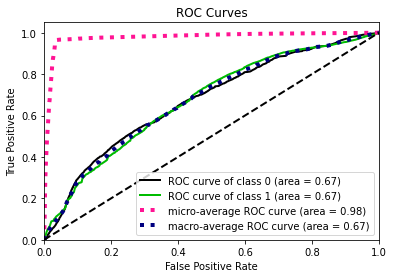

In [126]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_roc_curve(y_test.to_numpy(), preds_proba)
plt.show()

In [127]:
y_train.mean()

0.08985583967293787

In [128]:
pred_proba_mean = np.ones(y_test.to_numpy().shape) * y_train.mean()
pred_proba_mean

array([0.08985584, 0.08985584, 0.08985584, ..., 0.08985584, 0.08985584,
       0.08985584])

In [129]:
pred_proba_mean = np.array([1 - pred_proba_mean, pred_proba_mean])
pred_proba_mean

array([[0.91014416, 0.91014416, 0.91014416, ..., 0.91014416, 0.91014416,
        0.91014416],
       [0.08985584, 0.08985584, 0.08985584, ..., 0.08985584, 0.08985584,
        0.08985584]])

In [130]:
pred_proba_mean = pred_proba_mean.transpose()
pred_proba_mean

array([[0.91014416, 0.08985584],
       [0.91014416, 0.08985584],
       [0.91014416, 0.08985584],
       ...,
       [0.91014416, 0.08985584],
       [0.91014416, 0.08985584],
       [0.91014416, 0.08985584]])

In [131]:
auc = metrics.roc_auc_score(y_test.to_numpy(), pred_proba_mean[:,1])
auc


0.5

In [132]:
logloss = metrics.log_loss(y_test.to_numpy(), pred_proba_mean[:,1])
logloss

0.1761131508502764

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


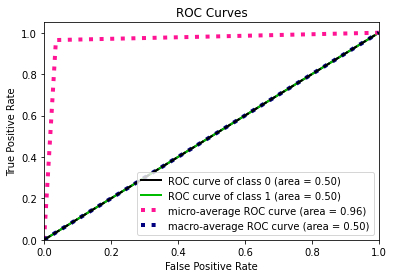

In [133]:
skplt.metrics.plot_roc_curve(y_test.to_numpy(), pred_proba_mean)
plt.show()

AUC value of model on final day is: 0.6733805744948257


Log-loss value of model on final day is: 0.22424336576689596

As we can see on AUC graph our model is better then baseline